# Machine Learning Lab Project - Credit Card Overdue Likelihood Prediction
##  Business Understanding

## Data Understanding
The data for this task is taken from [this](https://www.kaggle.com/datasets/rikdifos/credit-card-approval-prediction) kaggle dataset. The kaggle page provides two `.csv` files:
- application_record.csv
- credit_record.csv

On a simple level, `application_record.csv` contains the customer data and `credit_record.csv` contains the customers credit history. The specific content is now investigated further.

For beeing able to analyse the datasets, the necessary libraries are imported first:

In [58]:
import pandas as pd
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pandas as pd
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In this next step the two `.csv` files are loaded into a pandas datafram. This enables an analysis with the full pandas funcionality, which makes the data understanding process way easier.

In [59]:
customer_df = pd.read_csv("Data/application_record.csv")
credit_df = pd.read_csv("Data/credit_record.csv")

### application_record.csv
First, it is important to analyse the columns of the dataset:

In [60]:
customer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   438557 non-null  int64  
 1   CODE_GENDER          438557 non-null  object 
 2   FLAG_OWN_CAR         438557 non-null  object 
 3   FLAG_OWN_REALTY      438557 non-null  object 
 4   CNT_CHILDREN         438557 non-null  int64  
 5   AMT_INCOME_TOTAL     438557 non-null  float64
 6   NAME_INCOME_TYPE     438557 non-null  object 
 7   NAME_EDUCATION_TYPE  438557 non-null  object 
 8   NAME_FAMILY_STATUS   438557 non-null  object 
 9   NAME_HOUSING_TYPE    438557 non-null  object 
 10  DAYS_BIRTH           438557 non-null  int64  
 11  DAYS_EMPLOYED        438557 non-null  int64  
 12  FLAG_MOBIL           438557 non-null  int64  
 13  FLAG_WORK_PHONE      438557 non-null  int64  
 14  FLAG_PHONE           438557 non-null  int64  
 15  FLAG_EMAIL       

As can be seen above, the dataset consists of 17 columns, containing numeral as well as textual data. It also seems as if there is already an unique identifier for every customer in the column `ID`. A concrete description fo these different columns can be retrieved from the datasets [kaggle page](https://www.kaggle.com/datasets/rikdifos/credit-card-approval-prediction/data):

|Feature name|Explanation|Remarks|
|:-----------|:----------|:------|
|ID 	     |Client number||
|CODE_GENDER |	Gender 	||
|FLAG_OWN_CAR| 	Is there a car 	||
|FLAG_OWN_REALTY| 	Is there a property|| 	
|CNT_CHILDREN| 	Number of children 	||
|AMT_INCOME_TOTAL| 	Annual income 	||
|NAME_INCOME_TYPE| 	Income category 	||
|NAME_EDUCATION_TYPE| 	Education level ||	
|NAME_FAMILY_STATUS| 	Marital status 	||
|NAME_HOUSING_TYPE| 	Way of living 	||
|DAYS_BIRTH| 	Birthday |	Count backwards from current day (0), -1 means yesterday|
|DAYS_EMPLOYED| 	Start date of employment |	Count backwards from current day(0). If positive, it means the person currently  unemployed.|
|FLAG_MOBIL| 	Is there a mobile phone 	||
|FLAG_WORK_PHONE| 	Is there a work phone 	||
|FLAG_PHONE| 	Is there a phone 	||
|FLAG_EMAIL| 	Is there an email 	||
|OCCUPATION_TYPE| 	Occupation 	||
|CNT_FAM_MEMBERS| 	Family size||

Now that the purpose of the columns is clear, the actual data can be analyzed:

In [61]:
customer_df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


From these first five entries several things can be observed:
1. The ID does not start from 0 but seems to be unique.
2. For the `CODE_GENDER` the flags `F` (Female) and `M` (Male) are used.
3. For `FLAG_OWN_CAR` and `FLAG_OWN_REALTY` the flags `Y` (Yes) and `N` (No) are used.
4. For `NAME_INCOME_TYPE`, `NAME_EDUCATION_TYPE`, `NAME_FAMILY_STATUS` and `NAME_HOUSING_TYPE` are textual fields, but seem to have only a few different values.
5. `OCCUPATION_TYPE` is a textual field and the values seem to be very different ("Freetext Field").
6. For `FLAG_MOBIL`, `FLAG_WORK_PHONE`, `FLAG_PHONE` and `FLAG_EMAIL` the flags 1 (Yes) and 0 (No) are used.

Before basing the data perparation on these findings, the assumptions have to be validated:

#### 1. Unique `ID`

In [62]:
customer_df['ID'].value_counts()

ID
7137299    2
7702238    2
7282535    2
7243768    2
7050948    2
          ..
5690727    1
6621262    1
6621261    1
6621260    1
6842885    1
Name: count, Length: 438510, dtype: int64

The ouptut of the value count clearly shows that not every ID is unique. As some IDs are contained twice, the real amout of customers contained in the dataset is only 438510.
#### 2. Gender

In [63]:
customer_df['CODE_GENDER'].value_counts()

CODE_GENDER
F    294440
M    144117
Name: count, dtype: int64

For the gender the assumption that only the flags `F` and `M` are used was correct.
#### 3. Flag Car / Real-Estate

In [64]:
print(customer_df['FLAG_OWN_CAR'].value_counts())
print(customer_df['FLAG_OWN_REALTY'].value_counts())

FLAG_OWN_CAR
N    275459
Y    163098
Name: count, dtype: int64
FLAG_OWN_REALTY
Y    304074
N    134483
Name: count, dtype: int64


Also for the flags for the possesion of car and real-estate the assumption that there are only the flags `Y` and `N` was correct.
#### 4. Text fields income, education, family and housing

In [65]:
customer_df['NAME_INCOME_TYPE'].value_counts()

NAME_INCOME_TYPE
Working                 226104
Commercial associate    100757
Pensioner                75493
State servant            36186
Student                     17
Name: count, dtype: int64

As can be seen above, there are five different types of income. This means the column can be encoded without any problems and can be used for the modeling later.

In [66]:
customer_df['NAME_EDUCATION_TYPE'].value_counts()

NAME_EDUCATION_TYPE
Secondary / secondary special    301821
Higher education                 117522
Incomplete higher                 14851
Lower secondary                    4051
Academic degree                     312
Name: count, dtype: int64

The education field also consists of only five types and can therefore also be used for modelling without any problems.

In [67]:
customer_df['NAME_FAMILY_STATUS'].value_counts()

NAME_FAMILY_STATUS
Married                 299828
Single / not married     55271
Civil marriage           36532
Separated                27251
Widow                    19675
Name: count, dtype: int64

Also the family status has five different values.

In [68]:
customer_df['NAME_HOUSING_TYPE'].value_counts()

NAME_HOUSING_TYPE
House / apartment      393831
With parents            19077
Municipal apartment     14214
Rented apartment         5974
Office apartment         3922
Co-op apartment          1539
Name: count, dtype: int64

The housing has six different values, which is still acceptable.
#### 5. Text field occupation type

In [69]:
print(customer_df['OCCUPATION_TYPE'].value_counts())
print("Amount of null values: ", customer_df['OCCUPATION_TYPE'].isnull().sum())

OCCUPATION_TYPE
Laborers                 78240
Core staff               43007
Sales staff              41098
Managers                 35487
Drivers                  26090
High skill tech staff    17289
Accountants              15985
Medicine staff           13520
Cooking staff             8076
Security staff            7993
Cleaning staff            5845
Private service staff     3456
Low-skill Laborers        2140
Secretaries               2044
Waiters/barmen staff      1665
Realty agents             1041
HR staff                   774
IT staff                   604
Name: count, dtype: int64
Amount of null values:  134203


Even though there are way less different values than expected (only 18), the column contains many null values, which may make it difficult to work with it.
#### 6. Contact method flags

In [70]:
print(customer_df['FLAG_MOBIL'].value_counts())
print(customer_df['FLAG_WORK_PHONE'].value_counts())
print(customer_df['FLAG_PHONE'].value_counts())
print(customer_df['FLAG_EMAIL'].value_counts())

FLAG_MOBIL
1    438557
Name: count, dtype: int64
FLAG_WORK_PHONE
0    348156
1     90401
Name: count, dtype: int64
FLAG_PHONE
0    312353
1    126204
Name: count, dtype: int64
FLAG_EMAIL
0    391102
1     47455
Name: count, dtype: int64


As expected, these columns only use the flags `1` and `0`. On top of that, column `FLAG_MOBIL` only contains the value `1`, which means all customers at least are registered with a mobile phone. Therefore, this column can be left out completely.
### credit_record.csv
Again, first analyze the columns:

In [71]:
credit_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   ID              1048575 non-null  int64 
 1   MONTHS_BALANCE  1048575 non-null  int64 
 2   STATUS          1048575 non-null  object
dtypes: int64(2), object(1)
memory usage: 24.0+ MB


As can be seen above, this table only contains three columns. According to the [kaggle page](https://www.kaggle.com/datasets/rikdifos/credit-card-approval-prediction/data), these columns mean the following:

|Feature name| 	Explanation |	Remarks|
|:-|:-|:-|
|ID |	Client number 	||
|MONTHS_BALANCE |	Record month |	The month of the extracted data is the starting point, backwards, 0 is the current month, -1 is the previous month, and so on|
|STATUS |	Status| 	0: 1-29 days past due 1: 30-59 days past due 2: 60-89 days overdue 3: 90-119 days overdue 4: 120-149 days overdue 5: Overdue or bad debts, write-offs for more than 150 days C: paid off that month X: No loan for the month|

Checking for unique `ID` values now reveals for how many customers there exists credit data:

In [72]:
len(credit_df['ID'].unique())

45985

There is only credit data for 45985 customers, that means only parts of the `customer_df` can be used.
As a last step check the values of the `STATUS` column:

In [73]:
credit_df['STATUS'].value_counts()

print(credit_df)

              ID  MONTHS_BALANCE STATUS
0        5001711               0      X
1        5001711              -1      0
2        5001711              -2      0
3        5001711              -3      0
4        5001712               0      C
...          ...             ...    ...
1048570  5150487             -25      C
1048571  5150487             -26      C
1048572  5150487             -27      C
1048573  5150487             -28      C
1048574  5150487             -29      C

[1048575 rows x 3 columns]


The information given on the kaggle page is correct, only the stated flags are used.
### Summary
Overall, the dataset consists of two parts: the customer data and the credit data. The customer data mostly contains information about income, job, family situation and contact methods as these are important aspects for evaluating the creditworthiness. The credit data is basically a credit history overview, showing for a given custumer and month if the credit was paid back on time. This credit data can now be used for calculating an "overdue_likelyhood" for every customer which states how likely it is for this specific customer to not pay it's credit back in time. This is an important information for a credit institute. Based on all the findings in this section the two datasets can now be prepared, connected and finally used for training a machine learning model.

## Data Preparation

Get the overdue likelyhood for the customers:

STATUS    0  1  2  3  4  5   C   X
ID                                
5001711   3  0  0  0  0  0   0   1
5001712  10  0  0  0  0  0   9   0
5001713   0  0  0  0  0  0   0  22
5001714   0  0  0  0  0  0   0  15
5001715   0  0  0  0  0  0   0  60
...      .. .. .. .. .. ..  ..  ..
5150482  12  0  0  0  0  0   6   0
5150483   0  0  0  0  0  0   0  18
5150484  12  0  0  0  0  0   1   0
5150485   2  0  0  0  0  0   0   0
5150487   0  0  0  0  0  0  30   0

[45985 rows x 8 columns]
STATUS       ID  overdue_likelihood
1       5001712            0.550000
2       5001713            1.000000
5       5001717            0.782609
6       5001718            0.900000
7       5001719            0.068182
The number of entries with NaN values in overdue_likelihood: 0


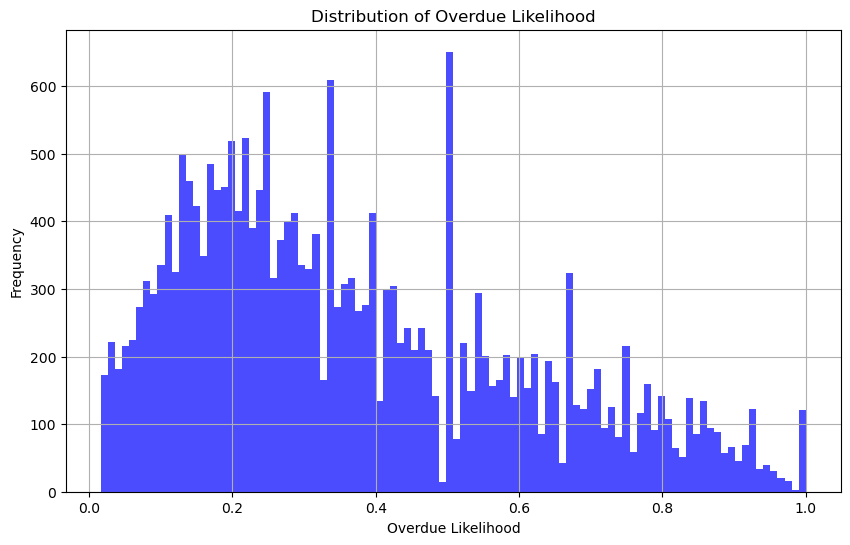

STATUS,ID,overdue_likelihood
STATUS,,
ID,1.000000,0.027848
overdue_likelihood,0.027848,1.000000


In [74]:
grouped_df = credit_df.groupby('ID')['STATUS'].value_counts().unstack(fill_value=0)

print(grouped_df)

grouped_df['overdue_likelihood'] = 1 - (grouped_df['C'] / (grouped_df.sum(axis=1) - grouped_df['X']+ 1))
result_df = grouped_df.reset_index()[['ID', 'overdue_likelihood']]

probability_mask = (np.random.rand(len(result_df)) < 0.005) | (result_df['overdue_likelihood'] != 1.0)
result_df = result_df[probability_mask]

print(result_df.head())

nan_count = result_df['overdue_likelihood'].isna().sum()

print(f'The number of entries with NaN values in overdue_likelihood: {nan_count}')

# Plot the distribution of overdue likelihood
plt.figure(figsize=(10, 6))
plt.hist(result_df['overdue_likelihood'].dropna(), bins=100, alpha=0.7, color='blue')
plt.title('Distribution of Overdue Likelihood')
plt.xlabel('Overdue Likelihood')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

result_df.corr()


That means ca. 33110 customers are really usable.

Remove NaN entrys

In [75]:
result_df.dropna(subset=['overdue_likelihood'], inplace=True)
nan_count = result_df['overdue_likelihood'].isna().sum()

print(f'The number of entries with NaN values in overdue_likelihood: {nan_count}')

The number of entries with NaN values in overdue_likelihood: 0


Merge the data:

In [76]:
merged_df = pd.merge(customer_df, result_df, on='ID', how='inner')
print(merged_df.head())

        ID CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  \
0  5008804           M            Y               Y             0   
1  5008805           M            Y               Y             0   
2  5008806           M            Y               Y             0   
3  5008810           F            N               Y             0   
4  5008811           F            N               Y             0   

   AMT_INCOME_TOTAL      NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
0          427500.0               Working               Higher education   
1          427500.0               Working               Higher education   
2          112500.0               Working  Secondary / secondary special   
3          270000.0  Commercial associate  Secondary / secondary special   
4          270000.0  Commercial associate  Secondary / secondary special   

     NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  DAYS_BIRTH  DAYS_EMPLOYED  \
0        Civil marriage   Rented apartment      -12005 

In [77]:
one_hot_cols = ['NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS','NAME_INCOME_TYPE','NAME_HOUSING_TYPE','OCCUPATION_TYPE']
ordinal_cols = ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'FLAG_MOBIL','FLAG_WORK_PHONE',  'FLAG_PHONE', 'FLAG_EMAIL']

merged_df['OCCUPATION_TYPE'].fillna('NaN', inplace=True)
merged_df.fillna(0, inplace=True)

merged_df = merged_df.drop('ID', axis=1)
df_proc = merged_df.copy()

#Ordinal Encoder
ordinal_encoder = OrdinalEncoder()
df_proc[ordinal_cols] = ordinal_encoder.fit_transform(df_proc[ordinal_cols])

#Onehot Encoder
df_enc = pd.get_dummies(df_proc, columns=one_hot_cols)

cols_except_overdue_likelihood = [col for col in df_enc.columns if col != 'overdue_likelihood']
df_enc[cols_except_overdue_likelihood] = df_enc[cols_except_overdue_likelihood].astype(int)

if 'overdue_likelihood' in df_enc.columns:
    overdue_col = df_enc['overdue_likelihood']
    df_enc.drop(labels=['overdue_likelihood'], axis=1, inplace=True)
    df_enc['overdue_likelihood'] = overdue_col
else:
    print("Column 'overdue_likelihood' not found in DataFrame")
print(df_enc.head())

   CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  \
0            1             1                1             0            427500   
1            1             1                1             0            427500   
2            1             1                1             0            112500   
3            0             0                1             0            270000   
4            0             0                1             0            270000   

   DAYS_BIRTH  DAYS_EMPLOYED  FLAG_MOBIL  FLAG_WORK_PHONE  FLAG_PHONE  ...  \
0      -12005          -4542           0                1           0  ...   
1      -12005          -4542           0                1           0  ...   
2      -21474          -1134           0                0           0  ...   
3      -19110          -3051           0                0           1  ...   
4      -19110          -3051           0                0           1  ...   

   OCCUPATION_TYPE_Managers  OCCUPATION_TYPE

In [78]:
#The data is very inhomogenous. The neural network works best with a lot of data. To loose no data, oversampling is a good way
#to create additional data.
#To do this, we duplicate existing data entries and slightly randomize it. Tests have shown that randomizing the data has no
#significant impact on the neural network - it doesn't learn the randomize function.
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(df_enc)
df_scaled = pd.DataFrame(X_scaled, columns=df_enc.columns)

# Define the target count for each group -> 8000 mean 0.8 mil data entries
target_count_per_group = 0

augmented_df = pd.DataFrame()

# Define a function to apply noise
def apply_noise(series, noise_level=0.01):
    noise = np.random.uniform(-noise_level, noise_level, series.shape)
    return series + noise

overdue_likelihood_scaled = df_scaled.iloc[:, -1]

# Group the data based on the scaled 'overdue_likelihood'
for i in range(100):
    lower_bound = i / 100
    upper_bound = (i + 1) / 100
    group_df = df_scaled[(overdue_likelihood_scaled >= lower_bound) & (overdue_likelihood_scaled < upper_bound)]
    duplicates_needed = target_count_per_group - len(group_df)
    
    if duplicates_needed > 0 and not group_df.empty:
        duplicated_rows = pd.concat([group_df] * (duplicates_needed // len(group_df) + 1), ignore_index=True)
        duplicated_rows = duplicated_rows.iloc[:duplicates_needed, :]
        duplicated_rows.iloc[:, :-1] = apply_noise(duplicated_rows.iloc[:, :-1], noise_level=0.003)
        noise = np.random.uniform(-0.003, 0.003, size=(duplicated_rows.shape[0],))
        duplicated_rows['overdue_likelihood'] += noise
        group_df = pd.concat([group_df, duplicated_rows], ignore_index=True)  
    augmented_df = pd.concat([augmented_df, group_df], ignore_index=True)

# Shuffle
augmented_df = augmented_df.sample(frac=1).reset_index(drop=True)

# Scale again after applying randomness
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(augmented_df.drop('overdue_likelihood', axis=1))
Y_scaled = scaler.fit_transform(augmented_df[['overdue_likelihood']])

augmented_df = pd.DataFrame(X_scaled, columns=augmented_df.columns[:-1])
augmented_df['overdue_likelihood'] = Y_scaled.flatten()
Y = augmented_df['overdue_likelihood']
X_enc = augmented_df.drop('overdue_likelihood', axis=1)

print(augmented_df)


#The data is only slightly correlated. Some parameters show significantly more correlation with the overdue_likelihood then others.
#This can be used to enhance the input nodes of the neural network.
correlation_matrix = augmented_df.corr(method='pearson')
input_weights = correlation_matrix['overdue_likelihood'].drop('overdue_likelihood')
input_weights_array = input_weights.to_numpy()
max_weight = input_weights.abs().max()
scaled_weights = input_weights.abs() / max_weight
scaled_weights = scaled_weights.fillna(0)
scaled_weights_array = scaled_weights.to_numpy()

print(scaled_weights)

       CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
0              1.0           0.0              1.0      0.142857   
1              0.0           0.0              1.0      0.000000   
2              1.0           0.0              1.0      0.000000   
3              0.0           1.0              0.0      0.000000   
4              0.0           1.0              1.0      0.000000   
...            ...           ...              ...           ...   
18037          0.0           1.0              1.0      0.000000   
18038          1.0           0.0              0.0      0.000000   
18039          0.0           0.0              1.0      0.000000   
18040          1.0           1.0              1.0      0.000000   
18041          0.0           0.0              0.0      0.000000   

       AMT_INCOME_TOTAL  DAYS_BIRTH  DAYS_EMPLOYED  FLAG_MOBIL  \
0              0.113372    0.827594       0.034933         0.0   
1              0.069767    0.470652       0.038679         0.0 

# TODO:
- overdue-likelyhood zu labels
- encoden
    - Eig geht fast alles ordinal encoded
    - OCCUPATION_TYPE fliegt ganz raus
- scalen
- random forest




## Modeling

In [99]:
X_train, X_test, y_train, y_test = train_test_split(augmented_df, Y, test_size=0.2, random_state=0)
X_train = X_train.drop([
    'overdue_likelihood'], axis=1)
X_test = X_test.drop([
    'overdue_likelihood'], axis=1)

In [100]:
#To make the model configuration easier, create a config data container.
#Information about the current model configuration:
#As the data is very complex with 53 dimensions and very weak correlated, a very complex model proved to be optimal. We use
#2048 hidden layer neurons with 4 hidden layers. This ensures that the model is able to campture complex correlations while the 
#vanishing gradient problems impact isn't too great.
#Due to the models complexity and big data count, the training is very expensive, so GPU acceleration is used (~ 10min on RTX GPU)
config = {
    "input_size": X_enc.shape[1],  # Number of features in X_enc
    "hidden_size": 1024,  # Hidden layer neurons
    "output_size": 1,  # For regression
    "num_layers": 5,  # Number of hidden layers
    "num_epochs": 600,  # Number of epochs for training
    "batch_size": 64,  # Batch size for training
    "learning_rate": 0.0025,  # Learning rate for optimizer
    "dropout_rate": 0.0,  # Dropout rate for regularization (>0 to enable)
    "weight_decay": 0.0  # Weight decay for L2 regularization (>0 to enable)
}

In [101]:
# Convert data to NumPy arrays and then to PyTorch tensors
X_train = torch.tensor(X_train.values).float()
y_train = torch.tensor(y_train.values).float()
X_test = torch.tensor(X_test.values).float()
y_test = torch.tensor(y_test.values).float()
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
#Use the pytorch dataloader to enable the model to use batches
train_loader = DataLoader(
    train_dataset, 
    batch_size=config['batch_size'], 
    shuffle=True, 
    num_workers=4,
    pin_memory=True,
    persistent_workers=True
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=config['batch_size'], 
    shuffle=False,
    num_workers=4, 
    pin_memory=True
)

In [102]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader


class InputWeightingLayer(nn.Module):
    def __init__(self, weights):
        super(InputWeightingLayer, self).__init__()
        self.weights = nn.Parameter(torch.tensor(weights, dtype=torch.float32), requires_grad=False)

    def forward(self, x):
        weighted_x = x * self.weights
        return weighted_x

class MyModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, dropout_rate, input_weights):
        super(MyModel, self).__init__()
        self.input_weighting = InputWeightingLayer(input_weights)
        layers = [nn.Linear(input_size, hidden_size), nn.ReLU6()]
        for _ in range(num_layers - 2):
            layers.extend([nn.Linear(hidden_size, hidden_size), nn.ReLU6()])
        layers.append(nn.Linear(hidden_size, output_size))
        layers.append(nn.Sigmoid())
        self.layers = nn.Sequential(*layers)
    def forward(self, x):
        x = self.input_weighting(x)
        return self.layers(x)

input_weights = scaled_weights_array
    
model = MyModel(
    config['input_size'],
    config['hidden_size'],
    config['output_size'],
    config['num_layers'],
    config['dropout_rate'],
    input_weights
)


# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model.to(device)

# L1Loss (MAE) showed to be significantly more accurate then other loss functions
l1_loss = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])

# Training loop
for epoch in range(config['num_epochs']):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        # Forward pass
        outputs = model(inputs).squeeze(1)
        loss = l1_loss(outputs, labels)
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_loss = running_loss / len(train_loader)
    print(f'Epoch {epoch+1}/{config["num_epochs"]}, Loss: {epoch_loss:.4f}')


# Evaluation loop
model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.cuda(), labels.cuda()
        outputs = model(inputs)


Using device: cuda
Epoch 1/600, Loss: 0.1966
Epoch 2/600, Loss: 0.1947
Epoch 3/600, Loss: 0.1947
Epoch 4/600, Loss: 0.1934
Epoch 5/600, Loss: 0.1935
Epoch 6/600, Loss: 0.1927
Epoch 7/600, Loss: 0.1919
Epoch 8/600, Loss: 0.1921
Epoch 9/600, Loss: 0.1911
Epoch 10/600, Loss: 0.1906
Epoch 11/600, Loss: 0.1893
Epoch 12/600, Loss: 0.1884
Epoch 13/600, Loss: 0.1882
Epoch 14/600, Loss: 0.1866
Epoch 15/600, Loss: 0.1862
Epoch 16/600, Loss: 0.1856
Epoch 17/600, Loss: 0.1849
Epoch 18/600, Loss: 0.1837
Epoch 19/600, Loss: 0.1834
Epoch 20/600, Loss: 0.1828
Epoch 21/600, Loss: 0.1820
Epoch 22/600, Loss: 0.1815
Epoch 23/600, Loss: 0.1809
Epoch 24/600, Loss: 0.1802
Epoch 25/600, Loss: 0.1791
Epoch 26/600, Loss: 0.1789
Epoch 27/600, Loss: 0.1782
Epoch 28/600, Loss: 0.1774
Epoch 29/600, Loss: 0.1770
Epoch 30/600, Loss: 0.1764
Epoch 31/600, Loss: 0.1753
Epoch 32/600, Loss: 0.1750
Epoch 33/600, Loss: 0.1744
Epoch 34/600, Loss: 0.1736
Epoch 35/600, Loss: 0.1733
Epoch 36/600, Loss: 0.1728
Epoch 37/600, Loss

Epoch 297/600, Loss: 0.1270
Epoch 298/600, Loss: 0.1269
Epoch 299/600, Loss: 0.1268
Epoch 300/600, Loss: 0.1269
Epoch 301/600, Loss: 0.1273
Epoch 302/600, Loss: 0.1269
Epoch 303/600, Loss: 0.1273
Epoch 304/600, Loss: 0.1265
Epoch 305/600, Loss: 0.1259
Epoch 306/600, Loss: 0.1264
Epoch 307/600, Loss: 0.1261
Epoch 308/600, Loss: 0.1267
Epoch 309/600, Loss: 0.1266
Epoch 310/600, Loss: 0.1263
Epoch 311/600, Loss: 0.1259
Epoch 312/600, Loss: 0.1256
Epoch 313/600, Loss: 0.1263
Epoch 314/600, Loss: 0.1261
Epoch 315/600, Loss: 0.1264
Epoch 316/600, Loss: 0.1258
Epoch 317/600, Loss: 0.1262
Epoch 318/600, Loss: 0.1264
Epoch 319/600, Loss: 0.1265
Epoch 320/600, Loss: 0.1257
Epoch 321/600, Loss: 0.1256
Epoch 322/600, Loss: 0.1252
Epoch 323/600, Loss: 0.1256
Epoch 324/600, Loss: 0.1260
Epoch 325/600, Loss: 0.1256
Epoch 326/600, Loss: 0.1264
Epoch 327/600, Loss: 0.1249
Epoch 328/600, Loss: 0.1251
Epoch 329/600, Loss: 0.1247
Epoch 330/600, Loss: 0.1256
Epoch 331/600, Loss: 0.1248
Epoch 332/600, Loss:

Epoch 590/600, Loss: 0.1167
Epoch 591/600, Loss: 0.1171
Epoch 592/600, Loss: 0.1164
Epoch 593/600, Loss: 0.1166
Epoch 594/600, Loss: 0.1164
Epoch 595/600, Loss: 0.1161
Epoch 596/600, Loss: 0.1165
Epoch 597/600, Loss: 0.1165
Epoch 598/600, Loss: 0.1169
Epoch 599/600, Loss: 0.1160
Epoch 600/600, Loss: 0.1166


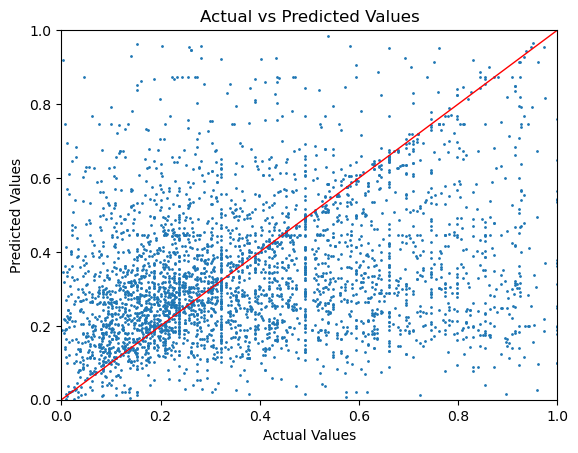

In [103]:
# Switch the model to evaluation mode
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.cuda()

        # Forward pass
        outputs = model(inputs)
        outputs = outputs.squeeze(1)

        # Store predictions and labels
        all_preds.extend(outputs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Plot the results
plt.scatter(all_labels, all_preds, s=1)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')

# Identity line for reference
plt.plot([0, 1], [0, 1], color='red', linestyle='-', linewidth=1)

plt.xlim([0, 1])
plt.ylim([0, 1])

plt.show()

With the current configuration, mean deviation of arround 17% can be achieved, meaning that this model is still more precise then most other models we tested, especially considering it is a regressor. While the majority of predictions from well represented parts of the data stay arround the expected value, there is a big amount of outliers due to the data inhomogenities. There is no synthetic data in this dataset, leading to bad results in cases with higher overdue likelihood.

In [104]:
#Some singular tests
num_examples = 5
example_indices = np.random.choice(len(test_dataset), num_examples, replace=False)  # Randomly select indices

# Display the examples
for idx in example_indices:
    # Extract the example and its corresponding label
    example, actual_label = test_dataset[idx]
    example_input = example.unsqueeze(0).cuda()
    with torch.no_grad():
        model.eval()
        predicted_label = model(example_input).squeeze(1).cpu().numpy()
    gender = 'Male' if example[0] >= 0.5 else 'Female'
    owns_car = 'Yes' if example[1] >= 0.5 else 'No'
    owns_realty = 'Yes' if example[2] >= 0.5 else 'No'
    num_children = example[3]
    total_income = example[4]
    print(f"Example {idx+1}:")
    print(f"  Gender: {gender}")
    print(f"  Owns Car: {owns_car}")
    print(f"  Owns Realty: {owns_realty}")
    print(f"  Number of Children: {num_children}")
    print(f"  Total Income: {total_income}")
    print(f"  Actual Label: {actual_label}, Predicted Label: {predicted_label[0]}")
    print("------------------------------------------------------")

Example 1083:
  Gender: Female
  Owns Car: Yes
  Owns Realty: Yes
  Number of Children: 0.1428571492433548
  Total Income: 0.040697675198316574
  Actual Label: 0.4423182010650635, Predicted Label: 0.42712536454200745
------------------------------------------------------
Example 1580:
  Gender: Male
  Owns Car: Yes
  Owns Realty: No
  Number of Children: 0.1428571492433548
  Total Income: 0.12790697813034058
  Actual Label: 0.5480226278305054, Predicted Label: 0.29971423745155334
------------------------------------------------------
Example 3264:
  Gender: Male
  Owns Car: Yes
  Owns Realty: Yes
  Number of Children: 0.0
  Total Income: 0.15697674453258514
  Actual Label: 0.25847458839416504, Predicted Label: 0.5332990288734436
------------------------------------------------------
Example 3291:
  Gender: Female
  Owns Car: Yes
  Owns Realty: Yes
  Number of Children: 0.0
  Total Income: 0.12790697813034058
  Actual Label: 0.18644067645072937, Predicted Label: 0.44999071955680847
----